In [4]:
import librosa
import numpy as np
import os
import pickle
from tqdm import tqdm

def extract_mfcc_stft(file_path, n_mfcc=60):
    try:
        y, sr = librosa.load(file_path, sr=16000)

        # Apply pre-emphasis
        pre_emphasis = 0.98
        emphasized_signal = np.append(y[0], y[1:] - pre_emphasis * y[:-1])

        # Compute MFCCs
        mfccs = librosa.feature.mfcc(y=emphasized_signal, sr=sr, n_mfcc=n_mfcc, hop_length=512)
        delta2_mfccs = librosa.feature.delta(mfccs, order=2)

        # Compute STFT with Hanning window
        stft = np.abs(librosa.stft(emphasized_signal, n_fft=512, hop_length=512, window='hann'))

        # Compute Chroma features
        chroma = librosa.feature.chroma_stft(y=emphasized_signal, sr=sr, hop_length=512)

        # Compute statistics
        mfcc_mean = mfccs.mean(axis=1)
        delta2_mean = delta2_mfccs.mean(axis=1)

        stft_mean = stft.mean(axis=1)
        stft_var = stft.var(axis=1)
        stft_max = stft.max(axis=1)

        chroma_mean = chroma.mean(axis=1)
        chroma_var = chroma.var(axis=1)

        return mfcc_mean, delta2_mean, stft_mean, stft_var, stft_max, chroma_mean, chroma_var, None

    except Exception as e:
        return None, None, None, None, None, None, None, str(e)

def extract_features_from_folder(root_folder):
    all_data = []
    errors = []

    for dirpath, _, filenames in os.walk(root_folder):
        for file in tqdm(filenames, desc=f"Processing {dirpath}", leave=False):
            if file.endswith(('.wav', '.mp3')):
                file_path = os.path.join(dirpath, file)
                relative_path = os.path.relpath(file_path, root_folder)
                parts = relative_path.split(os.sep)

                category = parts[0] if len(parts) > 0 else "Unknown"
                subcategory = parts[1] if len(parts) > 1 else "Unknown"

                mfcc, delta2_mfcc, stft_mean, stft_var, stft_max, chroma_mean, chroma_var, error = extract_mfcc_stft(file_path)
                if mfcc is not None:
                    feature_row = {
                        'file_name': file,
                        'category': category,
                        'subcategory': subcategory,
                        'mfcc': mfcc,
                        'mfcc_delta2': delta2_mfcc,
                        'stft_mean': stft_mean,
                        'stft_var': stft_var,
                        'stft_max': stft_max,
                        'chroma_mean': chroma_mean,
                        'chroma_var': chroma_var
                    }
                    all_data.append(feature_row)
                else:
                    errors.append((file_path, error))

    return all_data, errors

def save_to_pickle(data, output_file):
    with open(output_file, 'wb') as f:
        pickle.dump(data, f)

if __name__ == "__main__":
    root_folder = r"C:\Users\Admin\Documents\Python Project\bee-swarming\SB1\buzz 1"
    output_folder = r"C:\Users\Admin\Documents\Python Project\bee-swarming\All_Features\buzz1"

    os.makedirs(output_folder, exist_ok=True)

    for subset in ["Test", "Train", "Val"]:
        subset_path = os.path.join(root_folder, subset)
        print(f"Processing {subset_path}...")

        features_data, errors = extract_features_from_folder(subset_path)

        output_file = os.path.join(output_folder, f"{subset}_features.pkl")
        save_to_pickle(features_data, output_file)
        print(f"Saved features for {subset} to {output_file}")

        if errors:
            error_log_file = os.path.join(output_folder, f"{subset}_errors.log")
            with open(error_log_file, "w", encoding="utf-8") as f:
                for file_path, error in errors:
                    f.write(f"{file_path}: {error}\n")
            print(f"Logged errors for {subset} in {error_log_file}")

    print("✅ Feature extraction completed!")


Processing C:\Users\Admin\Documents\Python Project\bee-swarming\SB1\buzz 1\Test...


Saved features for Test to C:\Users\Admin\Documents\Python Project\bee-swarming\All_Features\buzz1\Test_features.pkl
Processing C:\Users\Admin\Documents\Python Project\bee-swarming\SB1\buzz 1\Train...


Saved features for Train to C:\Users\Admin\Documents\Python Project\bee-swarming\All_Features\buzz1\Train_features.pkl
Processing C:\Users\Admin\Documents\Python Project\bee-swarming\SB1\buzz 1\Val...


Saved features for Val to C:\Users\Admin\Documents\Python Project\bee-swarming\All_Features\buzz1\Val_features.pkl
✅ Feature extraction completed!


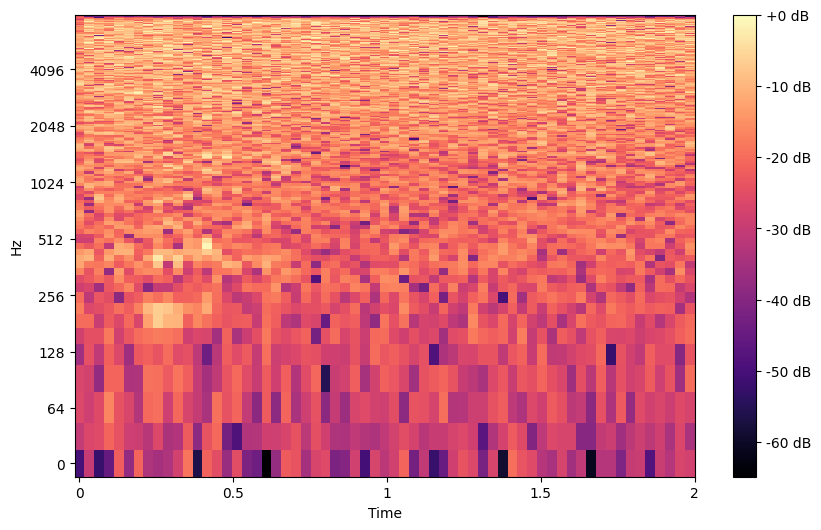

In [7]:
import librosa.display
import matplotlib.pyplot as plt

def plot_spectrogram(file_path):
    # Load the audio file
    y, sr = librosa.load(file_path, sr=16000)

    # Apply pre-emphasis
    pre_emphasis = 0.98
    emphasized_signal = np.append(y[0], y[1:] - pre_emphasis * y[:-1])

    # Compute the Short-Time Fourier Transform (STFT)
    stft = np.abs(librosa.stft(emphasized_signal, n_fft=512, hop_length=512, window='hann'))

    # Plot the spectrogram
    plt.figure(figsize=(10, 6))
    librosa.display.specshow(librosa.amplitude_to_db(stft, ref=np.max), sr=sr, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.show()

# Example usage
file_path = r"C:\Users\Admin\Documents\Python Project\bee-swarming\SB1\buzz 1\Train\Swarming\May 3_ Ngay 251222_ Bat dau 12h50_ Bay 13h15_ Ket thuc bay 14h15\May 3_ Ngay 251222_ Bat dau 12h50_ Bay 13h15_ Ket thuc bay 14h15_2.wav"
plot_spectrogram(file_path)
